In [ ]:
!wget https://github.com/nandakishormpai2001/Plant_Disease_Detector/raw/data/dataset.zip

In [ ]:
!unzip dataset.zip

In [ ]:
!pip install -r requirements.txt

In [2]:
from PIL import Image
import torch
import torchvision
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import pickle

In [3]:
class Dataset():
    def __init__(self):
        self.labels,self.images = self.load_data()

    # To load images and labels for dataloader
    def load_data(self):
        labels={}
        images = {}
        count = 0
        # setting resize dimensions
        resize = transforms.Compose([transforms.Resize((256,256))])
        main_dir = os.listdir(os.path.join("dataset","train"))
        reference = {}
        # iterating through categories
        for i,dir in enumerate(main_dir):
            reference[dir]=i
            images_list = os.listdir(os.path.join("dataset","train",dir))
            local_cnt = 0
            # iterating through images in a category
            for img in images_list:
                # 500 images from each category
                if local_cnt<500:
                    labels[count] = i
                    img_path = os.path.join("dataset","train",dir,img)
                    image = Image.open(img_path)
                    image = ToTensor()(image)
                    images[count] = resize(image)
                    count+=1
                    local_cnt+=1
                else:
                    break

        print(reference)
        return labels,images
      
    def __len__(self):
        return len(self.labels)
    

    # To return x,y values in each iteration over dataloader as batches.
    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.labels[idx],
        )

In [4]:
# Inherit from Dataset class
class ValDataset(Dataset):

    def load_data(self):
          labels={}
          images = {}
          count = 0
          resize = transforms.Compose([transforms.Resize((256,256))])
          main_dir = os.listdir(os.path.join("dataset","valid"))
          for i,dir in enumerate(main_dir):
              print(i,dir)
              images_list = os.listdir(os.path.join("dataset","valid",dir))
              local_cnt = 0
              for img in images_list:
                  if(local_cnt<100):
                      labels[count] = i
                      img_path = os.path.join("dataset","valid",dir,img)
                      image = Image.open(img_path)
                      image = ToTensor()(image)
                      images[count] = resize(image)
                      count+=1
                      local_cnt+=1
                  else:
                      break

          return labels,images


In [19]:
# Model Architecture
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # CNNs for rgb images 
        self.conv1= nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5)
        self.conv2= nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.conv3= nn.Conv2d(in_channels=12,out_channels=24,kernel_size=5)
        self.conv4= nn.Conv2d(in_channels=24,out_channels=48,kernel_size=5)
        
        # Connecting CNN outputs with Fully Connected layers
        self.fc1 = nn.Linear(in_features=48*12*12,out_features=240)
        self.fc2 = nn.Linear(in_features=240,out_features=120)
        self.out = nn.Linear(in_features=120,out_features=17)
        
        
    def forward(self,t):
        t = t
        
        t=self.conv1(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        
        t=self.conv2(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv3(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)

        t=self.conv4(t)
        t=F.relu(t)
        t=F.max_pool2d(t,kernel_size = 2, stride = 2)
        
        t=t.reshape(-1,48*12*12)
        t=self.fc1(t)
        t=F.relu(t)
        
        
        t=self.fc2(t)
        t=F.relu(t)
        
        t=self.out(t)
        
        
        return t

In [20]:
model = Network()

In [ ]:
dataset = Dataset()

In [ ]:
valdataset = ValDataset()

In [8]:
# Function to return number of correct predictions in a batch
def get_num_correct(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [14]:
def train(dataset,valdataset, model):
    model.train()

    # dataloader in pytorch to load validation and train dataset
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
    valdataloader = torch.utils.data.DataLoader(valdataset, batch_size=32,shuffle=True)

    # Defining the loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    num_of_epochs = 20
    epochs = []
    losses = []
    for epoch in range(num_of_epochs):
        cnt = 0
        tot_loss = 0
        tot_correct = 0
        for batch, (x, y) in enumerate(dataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            y_pred = model(x)
            # Compute loss (here CrossEntropyLoss)
            loss = F.cross_entropy(y_pred,y)

            loss.backward()
            optimizer.step()

        for batch, (x, y) in enumerate(valdataloader):
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                y_pred = model(x)
                # Compute loss (here CrossEntropyLoss)
                loss = F.cross_entropy(y_pred,y)

            tot_loss+=loss.item()
            tot_correct +=get_num_correct(y_pred,y)
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch",epoch,"total_correct",tot_correct,"loss:",tot_loss)
        torch.save(model.state_dict(), "model002_ep"+str(epoch+1)+".pth")

    # Plot a Validation Loss vs Epochs graph 
    plt.plot(epochs, losses, color='green', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=8) 
    plt.xlabel('epochs ---->',color='m',fontsize='xx-large' ) 
    plt.ylabel('loss ------>',color='m',fontsize='xx-large') 
    axes = plt.gca()        # 'gca' - get current axes
    axes.set_facecolor('c') #'c' - cyan
    axes.tick_params(axis='y', which='both', colors='tomato')
    axes.tick_params(axis='x', which='both', colors='#20ff14')
    plt.title("Val Loss vs Epoch",color='m',fontsize='xx-large')

Epoch 0 total_correct 413 loss: 121.73731422424316
Epoch 1 total_correct 725 loss: 91.92743670940399
Epoch 2 total_correct 790 loss: 84.59160953760147
Epoch 3 total_correct 977 loss: 70.20228296518326
Epoch 4 total_correct 1082 loss: 59.31371080875397
Epoch 5 total_correct 1139 loss: 51.01481255888939
Epoch 6 total_correct 1233 loss: 45.013969242572784
Epoch 7 total_correct 1267 loss: 43.16292858123779
Epoch 8 total_correct 1268 loss: 41.74965280294418
Epoch 9 total_correct 1321 loss: 36.72149619460106
Epoch 10 total_correct 1309 loss: 36.947828978300095
Epoch 11 total_correct 1303 loss: 40.06897500157356
Epoch 12 total_correct 1339 loss: 39.2538605928421
Epoch 13 total_correct 1304 loss: 46.184862941503525
Epoch 14 total_correct 1360 loss: 40.347060173749924
Epoch 15 total_correct 1284 loss: 56.35446451604366
Epoch 16 total_correct 1321 loss: 48.104191690683365
Epoch 17 total_correct 1321 loss: 48.540457010269165
Epoch 18 total_correct 1326 loss: 55.97410994768143
Epoch 19 total_corre

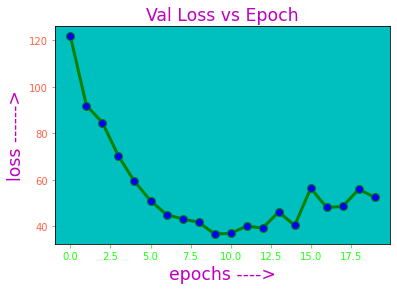

In [21]:
train(dataset,valdataset, model)

In [ ]:
# Saving labels to label value as a json
main_dir = os.listdir(os.path.join("minidataset","train"))
reference = {}
for i,dir in enumerate(main_dir):
    reference[dir]=i
with open('labels.json', 'wb') as iw:
    pickle.dump(reference, iw)

In [ ]:
#Save the trained model
torch.save(model.state_dict(), "model.pth")

In [ ]:
# prediction function to test
def predict(img_path):
    image = Image.open(img_path)
    image = ToTensor()(image)
    resize = transforms.Compose([transforms.Resize((256,256))])
    y_result = model(resize(image).unsqueeze(0))
    result_idx = y_result.argmax(dim=1)
    for key,value in reference.items():
        if(value==result_idx):
            print(key)
            break
      



In [ ]:
predict("img_path")

Potato___healthy
